## Importing libraries

In [26]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, './modules')
from Data_prep import Data
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

##  Define parameters required to create data

In [2]:
#define number of processors to use for parallel runs
num_procs = 4

#set verbose level for models
verbose_lvl = 0

#define input files
train_file = r'C:\Users\Admin\Desktop\Kaggle_Zillow Compitation\Raw Data\train_2016.csv'
properties_2016_file = r'C:\Users\Admin\Desktop\Kaggle_Zillow Compitation\Raw Data\properties_2016.csv'
test_file = r'C:\Users\Admin\Desktop\Kaggle_Zillow Compitation\Raw Data\train_2017.csv'
properties_2017_file = r'C:\Users\Admin\Desktop\Kaggle_Zillow Compitation\Raw Data\properties_2017.csv'


#define variables
cat_cols = ['hashottuborspa', 'propertycountylandusecode', 'fireplaceflag', 'taxdelinquencyflag']
num_cols = ['airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
        'propertylandusetypeid', 'regionidcity',
       'regionidcounty', 'roomcnt', 'storytypeid', 'threequarterbathnbr',
       'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount',
       'taxdelinquencyyear']
date_col = ['transactiondate']
target_col = 'logerror'
id_col = 'parcelid'

## Creating a data object 

In [3]:
data = Data(train_file, properties_2016_file, test_file, properties_2017_file , cat_cols, num_cols, date_col, target_col, id_col)

In [4]:
cols = list(set(data.train_df.columns).intersection(set(data.test_df.columns)))
data.train_df = data.train_df.loc[:,cols]
data.test_df = data.test_df.loc[:,cols]

In [6]:
data.train_df = data.train_df.sample(n = 10000,replace = True, random_state = 2)
data.train_df.shape

(10000, 119)

## Checking multi-collinearity of the variables and removing the highly correlated ones

In [8]:
X_vif = data.train_df.drop(['logerror','bathroomcnt','propertycountylandusecode_010E'],axis=1).assign(const=1)
pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],index=X_vif.columns)

propertycountylandusecode_1720           NaN
taxdelinquencyflag_nan                   inf
propertycountylandusecode_020M           NaN
hashottuborspa_True                      inf
roomcnt                            14.846552
                                     ...    
propertycountylandusecode_34      631.195638
unitcnt                            31.893058
propertycountylandusecode_010V      1.947116
latitude                            2.393195
const                               0.000000
Length: 117, dtype: float64

## Checking the property of homescedasticity .i.e. if the errors has any pattern or show growth

In [12]:
import statsmodels.api as sm

# Define X Values
X = sm.add_constant(data.train_df.drop('logerror',axis=1))

# Define Y 
Y = data.train_df.logerror

# Apply OLS to our X and Y
lm = sm.OLS(Y, X).fit()


Text(0, 0.5, 'Residuals')

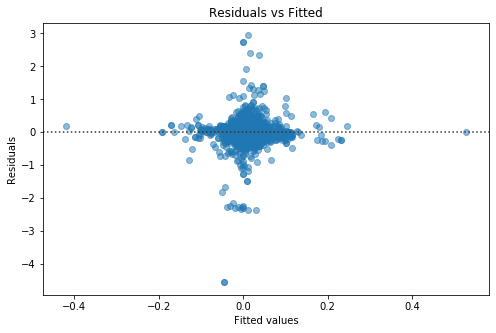

In [14]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(8)

model_fitted_y = lm.fittedvalues

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'logerror', data = data.train_df, 
                          scatter_kws={'alpha': 0.5})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

## Detecting Linearity, Normal Distribution of Residuals, & Zero Mean

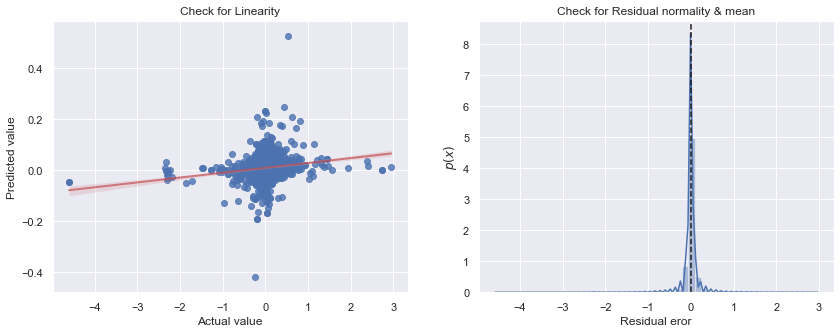

In [16]:
import seaborn as sns

# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
#sns.scatterplot(y_test,y_pred_ols,ax=ax,color=['r','g'])
# use the function regplot to make a scatterplot
sns.regplot(x=data.train_df.logerror, y=model_fitted_y, line_kws={"color":"r","alpha":0.7,"lw":2})
plt.title('Check for Linearity')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((data.train_df.logerror - model_fitted_y),ax=ax,color='b')
plt.axvline((data.train_df.logerror - model_fitted_y).mean(),color='k',linestyle='--')
plt.title('Check for Residual normality & mean')
plt.xlabel('Residual eror')
plt.ylabel('$p(x)$');

## Checking the normality of the residuals

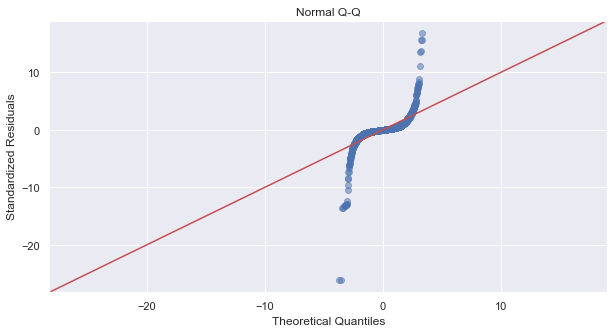

In [18]:
from statsmodels.graphics.gofplots import ProbPlot

# fitted values (need a constant term for intercept)
model_fitted_y = lm.fittedvalues

# model residuals
model_residuals = lm.resid

# normalized residuals
model_norm_residuals = lm.get_influence().resid_studentized_internal
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(5)
plot_lm_2.set_figwidth(10)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

## Modelling

In [19]:
X = data.train_df.drop('logerror',axis=1)
Y = data.train_df.logerror

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [21]:
lr = LinearRegression()

# Fit the model
lr.fit(X_train, y_train)

# Make predictions
predictions = lr.predict(X_test)

In [27]:
np.sqrt(mean_squared_error(y_test, predictions))

0.1664457990690364